In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import os

from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, GlobalAveragePooling2D, Dense, Dropout
from keras.layers import Input, Conv2D, ZeroPadding2D, BatchNormalization
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.utils import to_categorical


Using TensorFlow backend.


In [2]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [3]:
epi_img = nib.load('./ADNI_Train/002_S_0938_.nii')
# Get voxel array
epi_img_data = epi_img.get_fdata()
import sys
np.set_printoptions(threshold=sys.maxsize)



v_min = epi_img_data.min(axis=(0, 1, 2), keepdims=True)
v_max = epi_img_data.max(axis=(0, 1, 2), keepdims=True)
v = (epi_img_data - v_min)/(v_max - v_min)
print(np.max(v))

print(np.max(epi_img_data))
n_i, n_j, n_k = epi_img_data.shape
print("Image Shape",epi_img_data.shape)

1.0
3256.664306640625
Image Shape (256, 256, 166)


Text(0.5, 0.98, 'Center slices for EPI image')

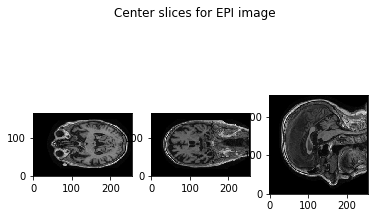

In [4]:
center_i = (n_i - 1) // 2  # // for integer division
center_j = (n_j - 1) // 2
center_k = (n_k - 1) // 2
slice_0 = epi_img_data[center_i, :, :]
slice_1 = epi_img_data[:, center_j, :]
slice_2 = epi_img_data[:, :, center_k]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image") 

In [5]:
base_model = ResNet50(weights="imagenet", include_top=False,
              input_tensor=Input(shape=(256, 256, 3)))

# for layer in base_model.layers:
#     layer.trainable = True

for layer in base_model.layers[-7:]:
    layer.trainable = True

/home/ben/.local/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [6]:
# Add layer to change output dims
# add a global spatial average pooling layer
from keras.regularizers import l2
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
# and a logistic layer -- 3 classes
predictions = Dense(3, activation='softmax')(x)
#predictions = Dense(2, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
# test with a single image
x = np.expand_dims(slice_2, axis=2)
x =  np.repeat(x, 3, axis=2)
x = np.expand_dims(x, axis=0)
#x = np.concatenate((x,x), axis = 0)
print("Input shape",x.shape)
x = preprocess_input(x)

Input shape (1, 256, 256, 3)


In [23]:
preds = model.predict(x)
print(preds)

[[1.4977294e-01 8.5014510e-01 8.1927254e-05]]


In [24]:
# DATA CLEANING

# Get folder of nii files only - 
#find Documents/CS230/MRI_git/ADNI -type f -print0 | xargs -0 mv -t Documents/CS230/MRI_git/ADNI_Clean/

# Change names of nii files
directory = "./ADNI_Clean/"
for filename in os.listdir(directory):
    if filename.startswith("ADNI"):
        os.rename(directory+filename, directory+filename[5:16]+".nii")

FileNotFoundError: [Errno 2] No such file or directory: './ADNI_Clean/'

[0 1 2 1 1]


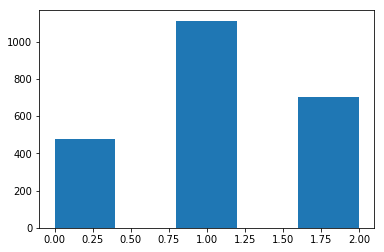

In [22]:
# Get data csv (Subject, Group)
patientData = np.loadtxt("ADNI1_Complete_1Yr_1.5T_10_26_2019.csv", 
                         dtype= 'str', skiprows=1, delimiter=',')

# One Hot Encode
num_cats = 3

# integer encode the document
integer_mapping = {x: i for i,x in enumerate(['AD', 'MCI', 'CN'])}
y = np.asarray([integer_mapping[word] for word in patientData[:,1]])
print(y[0:5])
labels = to_categorical(y, num_classes=num_cats, dtype='float32')

# print(integer_mapping)
# print(labels[0:5,:])
# print(y[0:5])
# print(patientData[0:5,:])

subject = patientData[1,0]
cat = patientData[1,1]

plt.hist(y,5)
plt.show()


In [8]:
def getImageSlice( sliceInt, subject, directory ):
    epi_img = nib.load(directory + subject + '.nii')
    # Get voxel array
    epi_img_data = epi_img.get_fdata()
    #Normalize
    v_min = epi_img_data.min(axis=(0, 1, 2), keepdims=True)
    v_max = epi_img_data.max(axis=(0, 1, 2), keepdims=True)
    epi_img_data = (epi_img_data - v_min)/(v_max - v_min)
    
    n_i, n_j, n_k = epi_img_data.shape

    center_i = (n_i - 1) // 2  # // for integer division
    center_j = (n_j - 1) // 2
    center_k = (n_k - 1) // 2
    
    if sliceInt == 0:
        sliceArr = epi_img_data[center_i, :, :]
    elif sliceInt == 1:
        sliceArr = epi_img_data[:, center_j, :]
    else: 
        sliceArr = epi_img_data[:, :, center_k]
        
    return sliceArr

In [38]:
def buildDataSet( patientData, sliceInt, labels, singleLabels ):
    
    directory = "./ADNI_Train/"
    for i, filename in enumerate(os.listdir(directory)):
        subject = filename[:-4]
        
        slice_2 = getImageSlice(sliceInt = 2, subject=subject, directory=directory)
        x = np.expand_dims(slice_2, axis=2)
        x = np.repeat(x, 3, axis=2)
        x = np.expand_dims(x, axis=0)

        ind = np.where(patientData[:,0] == subject[:-1])[0][0]
        y = labels[ind, :] 
        y = y.reshape(1,-1)
        #np.where(np.sum(t,axis=1)<1)

#         if y[0][1] == 0:
#             # remove MCI
#             y = np.delete(y,1,1)
        y = np.array([singleLabels[ind]])
        if i == 0:
            X = x
            Y = y
        else:
            if (X.shape[1] == x.shape[1] & X.shape[2] == x.shape[2]):
                X = np.concatenate((X,x), axis = 0)
                Y = np.concatenate((Y,y), axis = 0)
    return X, Y
    

In [39]:
X,Y = buildDataSet(patientData, 2, labels, y )
print(Y.shape)
print(X.shape)


(390,)
(390, 256, 256, 3)


In [46]:
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

X_flat = X[:,:,:,1].reshape(X.shape[0], -1)
print(X_flat.shape)
print(Y.shape)
X_train, X_test, y_train, y_test = train_test_split(X_flat, Y, test_size=0.3, shuffle=True)

SVM = svm.SVC(gamma=0.001)
SVM.fit(X_train, y_train)
predicted = SVM.predict(X_test)


(390, 65536)
(390,)


In [63]:
print("Classification report for classifier %s:\n%s\n"
      % (SVM, metrics.classification_report(y_test, predicted)))

# create a mesh to plot in
h = .02  
x = X[:,:2]
x_min, x_max = x.min() - 1, x.max() + 1
y_min, y_max = y.min() - 1, y.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
print(np.c_[xx.ravel(), yy.ravel()].shape)
Z = SVM.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

print(X_flat.shape)
plt.scatter(X_flat[:, 0], X_flat[:, 1], c=Y, cmap=plt.cm.coolwarm, s = 10)
plt.show()

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.42      0.98      0.59        48
           2       0.17      0.03      0.05        32

    accuracy                           0.41       117
   macro avg       0.20      0.34      0.21       117
weighted avg       0.22      0.41      0.26       117


(21400, 2)


/home/ben/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ValueError: X.shape[1] = 2 should be equal to 65536, the number of features at training time

In [11]:
# compile the keras model
# 'kullback_leibler_divergence
from keras import optimizers
adam = optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [12]:
X = preprocess_input(X)
# fit the keras model on the dataset
history = model.fit(X, Y, epochs=10, batch_size=1, verbose = 2, validation_split = 0.1, shuffle=True)

Train on 186 samples, validate on 21 samples
Epoch 1/10
 - 107s - loss: 14.0293 - accuracy: 0.4839 - val_loss: 13.6134 - val_accuracy: 0.7143
Epoch 2/10
 - 92s - loss: 13.3697 - accuracy: 0.5269 - val_loss: 12.9647 - val_accuracy: 0.7143
Epoch 3/10
 - 95s - loss: 12.7952 - accuracy: 0.5376 - val_loss: 12.4890 - val_accuracy: 0.5714
Epoch 4/10
 - 93s - loss: 12.1557 - accuracy: 0.6559 - val_loss: 11.9647 - val_accuracy: 0.5714
Epoch 5/10
 - 93s - loss: 11.6105 - accuracy: 0.7473 - val_loss: 11.5166 - val_accuracy: 0.6190
Epoch 6/10
 - 93s - loss: 10.9895 - accuracy: 0.8871 - val_loss: 10.9610 - val_accuracy: 0.7143
Epoch 7/10
 - 100s - loss: 10.4062 - accuracy: 0.9839 - val_loss: 10.7954 - val_accuracy: 0.5238
Epoch 8/10
 - 97s - loss: 9.8676 - accuracy: 1.0000 - val_loss: 10.2357 - val_accuracy: 0.6190
Epoch 9/10
 - 101s - loss: 9.4365 - accuracy: 1.0000 - val_loss: 10.1001 - val_accuracy: 0.4762
Epoch 10/10
 - 98s - loss: 9.0388 - accuracy: 1.0000 - val_loss: 9.8707 - val_accuracy: 0.

In [9]:
# #Save partly trained model
# model.save('train2MRI.h5')

#Load partly trained model
from keras.models import load_model
model = load_model('train1MRI.h5')

In [13]:
_, accuracy = model.evaluate(X, Y)
preds = model.predict(X)
print('Accuracy: %.2f' % (accuracy*100))

207/207 [==============================] - 21s 102ms/step
Accuracy: 85.02


In [15]:
print(np.round(preds))

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 

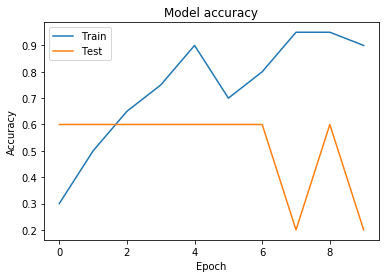

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

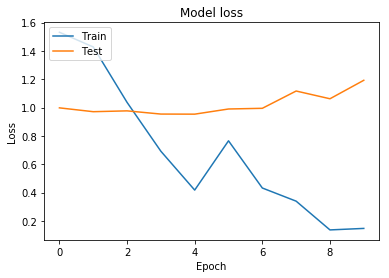

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
mlp = MLPClassifier(hidden_layer_sizes=(200,300,500,500,500,500,500), max_iter=200, alpha=1e-4,
                    solver='adam', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)

In [20]:
print(X_train.shape, y_train.shape)
mlp.fit(X_train.reshape(X_train.shape[0],-1), y_train)

(312, 256, 256, 3) (312, 3)


MemoryError: Unable to allocate array with shape (196608, 300) and data type float64

In [13]:
preds = mlp.predict(X_test.reshape(X_test.shape[0],-1))

In [14]:
preds[0:100]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0,